In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")
print("Random seed: 42")
np.random.seed(42)

Libraries imported successfully
Random seed: 42


## 1. Load Data and Define Constructs

In [22]:
# Load development sample
df_dev = pd.read_csv('../data/AIRS_clean_dev.csv')

print(f"Development sample: N = {len(df_dev)}")
print(f"Variables: {len(df_dev.columns)}")

Development sample: N = 159
Variables: 45


In [23]:
# Define 12 theoretical constructs with 2 items each
construct_items = {
    'PE': ['PE1', 'PE2'],  # Performance Expectancy
    'EE': ['EE1', 'EE2'],  # Effort Expectancy
    'SI': ['SI1', 'SI2'],  # Social Influence
    'FC': ['FC1', 'FC2'],  # Facilitating Conditions
    'HM': ['HM1', 'HM2'],  # Hedonic Motivation
    'PV': ['PV1', 'PV2'],  # Price Value
    'HB': ['HB1', 'HB2'],  # Habit
    'VO': ['VO1', 'VO2'],  # Voluntariness
    'TR': ['TR1', 'TR2'],  # Trust in AI
    'EX': ['EX1', 'EX2'],  # Explainability
    'ER': ['ER1', 'ER2'],  # Ethical Risk
    'AX': ['AX1', 'AX2']   # AI Anxiety
}

# All predictor items
all_predictor_items = [item for items in construct_items.values() for item in items]

# Outcome variable
outcome_items = ['BI1', 'BI2', 'BI3', 'BI4']

print(f"Constructs: {len(construct_items)}")
print(f"Total items (24): {len(all_predictor_items)}")
print(f"Outcome items (4): {len(outcome_items)}")

Constructs: 12
Total items (24): 24
Outcome items (4): 4


## 2. Item Selection: Best Item Per Construct

Strategy: Select the item with strongest loading from 24-item EFA (already run)

In [24]:
# Prepare full 24-item dataset
df_24items = df_dev[all_predictor_items].copy()

print(f"24-item dataset: N = {len(df_24items)}, items = {len(df_24items.columns)}")

# Quick EFA to get loadings (using Kaiser-suggested 4 factors based on previous analysis)
# Kaiser criterion: 4 factors, Parallel analysis: 3 factors
# We'll examine both 3, 4, and 5-factor solutions

print("\nRunning preliminary EFA to select best item per construct...")

24-item dataset: N = 159, items = 24

Running preliminary EFA to select best item per construct...


In [25]:
# Fit 4-factor model (Kaiser criterion from previous analysis)
fa_preliminary = FactorAnalyzer(n_factors=4, rotation='promax', method='minres')
fa_preliminary.fit(df_24items)

# Get loadings
loadings_24 = pd.DataFrame(
    fa_preliminary.loadings_,
    index=all_predictor_items,
    columns=[f'F{i+1}' for i in range(4)]
)

# For each item, find the maximum absolute loading (primary loading strength)
item_quality = []
for construct, items in construct_items.items():
    for item in items:
        max_loading = loadings_24.loc[item].abs().max()
        primary_factor = loadings_24.loc[item].abs().idxmax()
        item_quality.append({
            'Construct': construct,
            'Item': item,
            'Primary_Factor': primary_factor,
            'Max_Loading': max_loading
        })

item_quality_df = pd.DataFrame(item_quality)

print("\nItem Quality (primary loadings):")
print(item_quality_df.to_string(index=False))


Item Quality (primary loadings):
Construct Item Primary_Factor  Max_Loading
       PE  PE1             F1     0.766188
       PE  PE2             F1     0.612109
       EE  EE1             F2     0.387208
       EE  EE2             F1     0.411654
       SI  SI1             F2     0.585968
       SI  SI2             F2     0.588759
       FC  FC1             F2     0.903649
       FC  FC2             F2     0.774334
       HM  HM1             F1     0.801796
       HM  HM2             F1     0.780791
       PV  PV1             F1     0.912674
       PV  PV2             F1     0.978402
       HB  HB1             F1     0.884525
       HB  HB2             F1     0.949324
       VO  VO1             F1     0.720531
       VO  VO2             F4     0.575849
       TR  TR1             F1     0.777742
       TR  TR2             F1     0.722831
       EX  EX1             F2     0.535548
       EX  EX2             F4     0.488858
       ER  ER1             F3     0.710893
       ER  ER2      

In [26]:
# Select best item per construct (highest max loading)
selected_items = []
item_selection_summary = []

for construct, items in construct_items.items():
    construct_df = item_quality_df[item_quality_df['Construct'] == construct]
    best_item_row = construct_df.loc[construct_df['Max_Loading'].idxmax()]
    
    selected_items.append(best_item_row['Item'])
    item_selection_summary.append({
        'Construct': construct,
        'Selected_Item': best_item_row['Item'],
        'Primary_Factor': best_item_row['Primary_Factor'],
        'Max_Loading': best_item_row['Max_Loading'],
        'Item1_Loading': item_quality_df[(item_quality_df['Construct'] == construct) & 
                                          (item_quality_df['Item'] == items[0])]['Max_Loading'].values[0],
        'Item2_Loading': item_quality_df[(item_quality_df['Construct'] == construct) & 
                                          (item_quality_df['Item'] == items[1])]['Max_Loading'].values[0]
    })

selection_summary_df = pd.DataFrame(item_selection_summary)

print("="*70)
print("ITEM SELECTION: Best Item Per Construct (12-Item Scale)")
print("="*70)
print(selection_summary_df.to_string(index=False))

print(f"\n✓ Selected {len(selected_items)} items (1 per construct)")
print(f"\nSelected items: {', '.join(selected_items)}")

ITEM SELECTION: Best Item Per Construct (12-Item Scale)
Construct Selected_Item Primary_Factor  Max_Loading  Item1_Loading  Item2_Loading
       PE           PE1             F1     0.766188       0.766188       0.612109
       EE           EE2             F1     0.411654       0.387208       0.411654
       SI           SI2             F2     0.588759       0.585968       0.588759
       FC           FC1             F2     0.903649       0.903649       0.774334
       HM           HM1             F1     0.801796       0.801796       0.780791
       PV           PV2             F1     0.978402       0.912674       0.978402
       HB           HB2             F1     0.949324       0.884525       0.949324
       VO           VO1             F1     0.720531       0.720531       0.575849
       TR           TR1             F1     0.777742       0.777742       0.722831
       EX           EX1             F2     0.535548       0.535548       0.488858
       ER           ER1             F3    

## 3. Factor Analysis: 12-Item Scale

Now analyze the 12-item construct-balanced scale

In [27]:
# Create 12-item dataset
df_12items = df_dev[selected_items].copy()

print("="*70)
print("12-ITEM CONSTRUCT-BALANCED SCALE")
print("="*70)
print(f"\nDataset: N = {len(df_12items)}, Items = {len(df_12items.columns)}")
print(f"Sample-to-variable ratio: {len(df_12items)}/{len(df_12items.columns)} = {len(df_12items)/len(df_12items.columns):.1f}:1")

# Check missing data
missing = df_12items.isnull().sum().sum()
print(f"Missing values: {missing}")

if missing > 0:
    df_12items = df_12items.dropna()
    print(f"After listwise deletion: N = {len(df_12items)}")

12-ITEM CONSTRUCT-BALANCED SCALE

Dataset: N = 159, Items = 12
Sample-to-variable ratio: 159/12 = 13.2:1
Missing values: 0


### 3.1 Factorability Tests

In [28]:
# KMO test
kmo_all, kmo_model = calculate_kmo(df_12items)

print("="*70)
print("FACTORABILITY: 12-Item Scale")
print("="*70)

print(f"\n1. Kaiser-Meyer-Olkin (KMO): {kmo_model:.3f}")
if kmo_model >= 0.90:
    print("   ✓ Marvelous")
elif kmo_model >= 0.80:
    print("   ✓ Meritorious")
elif kmo_model >= 0.70:
    print("   ✓ Middling")
elif kmo_model >= 0.60:
    print("   ✓ Mediocre (Acceptable)")
else:
    print("   ⚠ Poor")

# Bartlett's test
from factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_12items)

print(f"\n2. Bartlett's Test of Sphericity")
print(f"   χ² = {chi_square_value:.2f}, p = {p_value:.4e}")
if p_value < 0.001:
    print("   ✓ Highly significant (p < .001)")
else:
    print("   ⚠ Not significant")

FACTORABILITY: 12-Item Scale

1. Kaiser-Meyer-Olkin (KMO): 0.906
   ✓ Marvelous

2. Bartlett's Test of Sphericity
   χ² = 1176.30, p = 6.2637e-203
   ✓ Highly significant (p < .001)


### 3.2 Determine Number of Factors

In [29]:
# Extract eigenvalues
fa_unrotated_12 = FactorAnalyzer(n_factors=len(df_12items.columns), rotation=None)
fa_unrotated_12.fit(df_12items)
eigenvalues_12, _ = fa_unrotated_12.get_eigenvalues()

# Kaiser criterion
kaiser_count_12 = np.sum(eigenvalues_12 > 1)

print("="*70)
print("FACTOR RETENTION: 12-Item Scale")
print("="*70)

print("\nEigenvalues:")
for i, ev in enumerate(eigenvalues_12, 1):
    status = "✓ > 1" if ev > 1 else ""
    print(f"  Factor {i:2d}: {ev:6.3f} {status}")

print(f"\nKaiser criterion (λ > 1): {kaiser_count_12} factors")

# Parallel analysis for 12 items
n_iterations = 100
random_eigenvalues_12 = []
for _ in range(n_iterations):
    random_data = np.random.normal(size=(len(df_12items), len(df_12items.columns)))
    fa_random = FactorAnalyzer(n_factors=len(df_12items.columns), rotation=None)
    fa_random.fit(random_data)
    random_ev, _ = fa_random.get_eigenvalues()
    random_eigenvalues_12.append(random_ev)

random_eigenvalues_95th_12 = np.percentile(random_eigenvalues_12, 95, axis=0)
parallel_factors_12 = np.sum(eigenvalues_12 > random_eigenvalues_95th_12)

print(f"Parallel analysis (95th percentile): {parallel_factors_12} factors")

print("\n" + "="*70)
print(f"RECOMMENDED: {parallel_factors_12}-factor solution (data-driven)")
print("="*70)

FACTOR RETENTION: 12-Item Scale

Eigenvalues:
  Factor  1:  6.321 ✓ > 1
  Factor  2:  1.495 ✓ > 1
  Factor  3:  0.794 
  Factor  4:  0.643 
  Factor  5:  0.570 
  Factor  6:  0.553 
  Factor  7:  0.386 
  Factor  8:  0.357 
  Factor  9:  0.274 
  Factor 10:  0.237 
  Factor 11:  0.201 
  Factor 12:  0.169 

Kaiser criterion (λ > 1): 2 factors
Parallel analysis (95th percentile): 2 factors

RECOMMENDED: 2-factor solution (data-driven)
Parallel analysis (95th percentile): 2 factors

RECOMMENDED: 2-factor solution (data-driven)


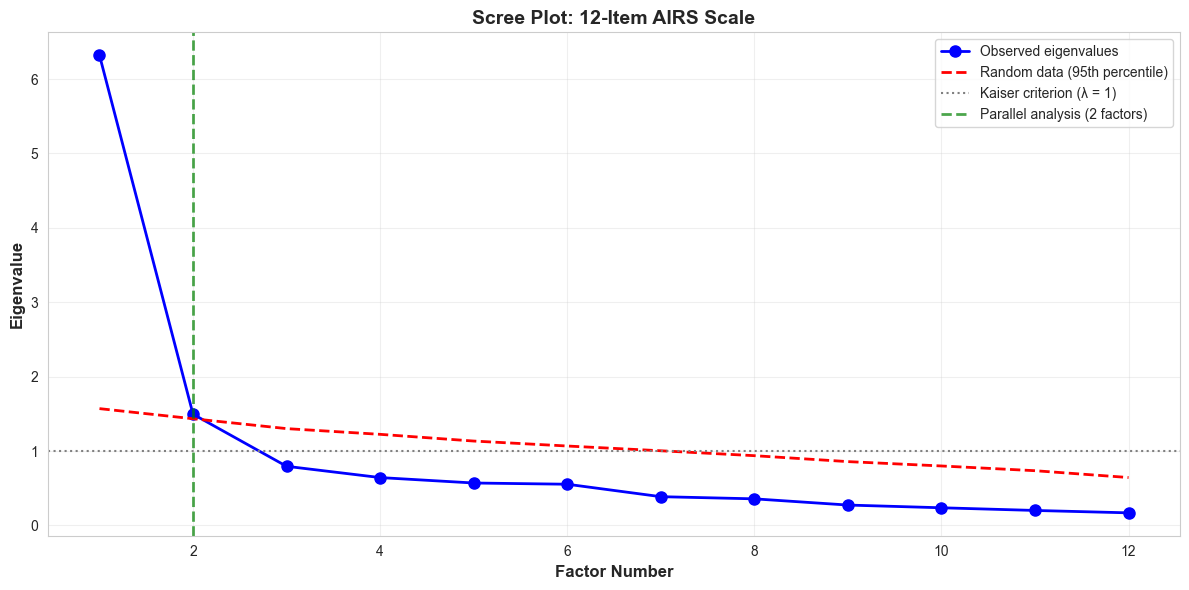


✓ Scree plot generated
  Eigenvalue at factor 2: 1.495
  Eigenvalue at factor 3: 0.794


In [30]:
# Scree plot
fig, ax = plt.subplots(figsize=(12, 6))

factors_12 = np.arange(1, len(eigenvalues_12) + 1)
ax.plot(factors_12, eigenvalues_12, 'bo-', linewidth=2, markersize=8, label='Observed eigenvalues')
ax.plot(factors_12, random_eigenvalues_95th_12, 'r--', linewidth=2, label='Random data (95th percentile)')
ax.axhline(y=1, color='gray', linestyle=':', linewidth=1.5, label='Kaiser criterion (λ = 1)')

# Highlight recommended solution
ax.axvline(x=parallel_factors_12, color='green', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Parallel analysis ({parallel_factors_12} factors)')

ax.set_xlabel('Factor Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Eigenvalue', fontsize=12, fontweight='bold')
ax.set_title('Scree Plot: 12-Item AIRS Scale', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Scree plot generated")
print(f"  Eigenvalue at factor {parallel_factors_12}: {eigenvalues_12[parallel_factors_12-1]:.3f}")
print(f"  Eigenvalue at factor {parallel_factors_12+1}: {eigenvalues_12[parallel_factors_12]:.3f}")

### 3.3 Extract Optimal Factor Solution

Based on parallel analysis recommendation

In [31]:
# Fit optimal model (using parallel analysis result)
n_factors_optimal = parallel_factors_12

fa_optimal = FactorAnalyzer(n_factors=n_factors_optimal, rotation='promax', method='minres')
fa_optimal.fit(df_12items)

# Loadings
loadings_optimal = pd.DataFrame(
    fa_optimal.loadings_,
    index=selected_items,
    columns=[f'F{i+1}' for i in range(n_factors_optimal)]
)

print("="*70)
print(f"{n_factors_optimal}-FACTOR SOLUTION (12-Item Scale)")
print("="*70)

# Variance explained
variance_optimal = fa_optimal.get_factor_variance()
variance_optimal_df = pd.DataFrame(
    variance_optimal,
    index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
    columns=[f'F{i+1}' for i in range(n_factors_optimal)]
)

print("\nVariance Explained:")
print(variance_optimal_df.round(3))
print(f"\nTotal variance: {variance_optimal[2][-1]:.1%}")

2-FACTOR SOLUTION (12-Item Scale)

Variance Explained:
                   F1     F2
SS Loadings     5.930  1.044
Proportion Var  0.494  0.087
Cumulative Var  0.494  0.581

Total variance: 58.1%


In [32]:
# Display loadings
print("\nFactor Loadings (12 items × {} factors):".format(n_factors_optimal))
print("\nRaw loadings:")
print(loadings_optimal.round(3))

# Highlight primary loadings
print("\nPrimary loadings (≥ 0.40):")
for item in selected_items:
    item_loads = loadings_optimal.loc[item]
    primary_factor = item_loads.abs().idxmax()
    primary_loading = item_loads[primary_factor]
    construct = selection_summary_df[selection_summary_df['Selected_Item'] == item]['Construct'].values[0]
    
    if abs(primary_loading) >= 0.40:
        marker = "✓"
    else:
        marker = "⚠"
    
    print(f"  {marker} {construct:3s} ({item}): {primary_factor} = {primary_loading:5.2f}")


Factor Loadings (12 items × 2 factors):

Raw loadings:
        F1     F2
PE1  0.806  0.050
EE2  0.740 -0.102
SI2  0.619  0.099
FC1  0.657  0.042
HM1  0.832 -0.018
PV2  0.907 -0.116
HB2  0.773  0.054
VO1  0.841 -0.111
TR1  0.786  0.106
EX1  0.663 -0.028
ER1 -0.148  0.750
AX2  0.137  0.644

Primary loadings (≥ 0.40):
  ✓ PE  (PE1): F1 =  0.81
  ✓ EE  (EE2): F1 =  0.74
  ✓ SI  (SI2): F1 =  0.62
  ✓ FC  (FC1): F1 =  0.66
  ✓ HM  (HM1): F1 =  0.83
  ✓ PV  (PV2): F1 =  0.91
  ✓ HB  (HB2): F1 =  0.77
  ✓ VO  (VO1): F1 =  0.84
  ✓ TR  (TR1): F1 =  0.79
  ✓ EX  (EX1): F1 =  0.66
  ✓ ER  (ER1): F2 =  0.75
  ✓ AX  (AX2): F2 =  0.64


### 3.4 Factor Interpretation

Map empirical factors to theoretical constructs

In [33]:
# Assign constructs to factors based on primary loadings
factor_composition = {f'F{i+1}': [] for i in range(n_factors_optimal)}

for item in selected_items:
    item_loads = loadings_optimal.loc[item]
    primary_factor = item_loads.abs().idxmax()
    primary_loading = item_loads[primary_factor]
    construct = selection_summary_df[selection_summary_df['Selected_Item'] == item]['Construct'].values[0]
    
    factor_composition[primary_factor].append({
        'Construct': construct,
        'Item': item,
        'Loading': primary_loading
    })

print("="*70)
print("FACTOR COMPOSITION")
print("="*70)

for factor in factor_composition:
    constructs_in_factor = factor_composition[factor]
    if len(constructs_in_factor) > 0:
        print(f"\n{factor}: {len(constructs_in_factor)} constructs")
        for c in sorted(constructs_in_factor, key=lambda x: abs(x['Loading']), reverse=True):
            print(f"  {c['Construct']:3s} ({c['Item']}): {c['Loading']:5.2f}")

FACTOR COMPOSITION

F1: 10 constructs
  PV  (PV2):  0.91
  VO  (VO1):  0.84
  HM  (HM1):  0.83
  PE  (PE1):  0.81
  TR  (TR1):  0.79
  HB  (HB2):  0.77
  EE  (EE2):  0.74
  EX  (EX1):  0.66
  FC  (FC1):  0.66
  SI  (SI2):  0.62

F2: 2 constructs
  ER  (ER1):  0.75
  AX  (AX2):  0.64


### 3.5 Factor Correlations

FACTOR CORRELATIONS


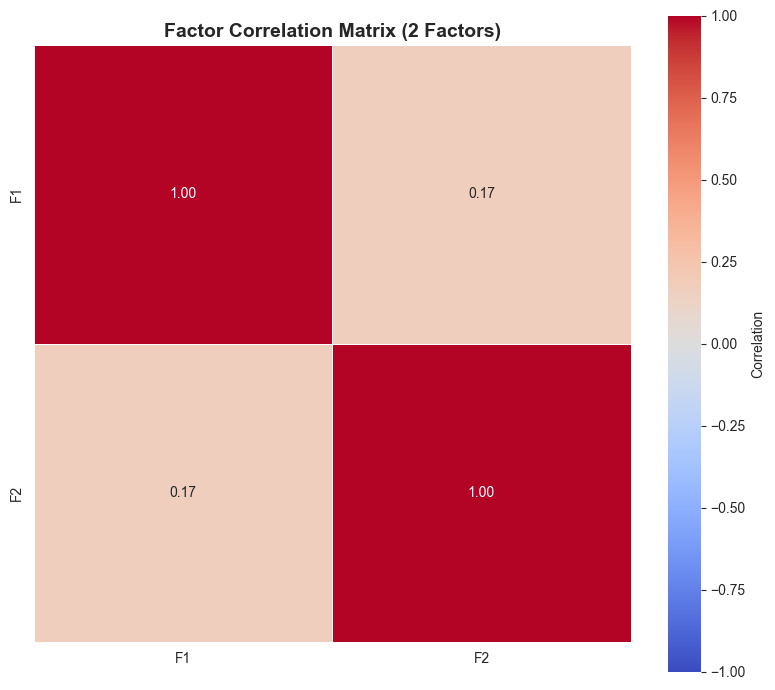


Factor correlation statistics:
  Mean: 0.166
  Median: 0.166
  Range: 0.166 to 0.166


In [34]:
# Factor correlation matrix (oblique rotation)
try:
    factor_corr_12 = pd.DataFrame(
        fa_optimal.phi_,
        index=[f'F{i+1}' for i in range(n_factors_optimal)],
        columns=[f'F{i+1}' for i in range(n_factors_optimal)]
    )
except AttributeError:
    # Fallback
    factor_corr_12 = pd.DataFrame(
        np.corrcoef(loadings_optimal.values.T),
        index=[f'F{i+1}' for i in range(n_factors_optimal)],
        columns=[f'F{i+1}' for i in range(n_factors_optimal)]
    )

print("="*70)
print("FACTOR CORRELATIONS")
print("="*70)

# Heatmap
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(factor_corr_12, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation'})
ax.set_title(f'Factor Correlation Matrix ({n_factors_optimal} Factors)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
off_diag_12 = factor_corr_12.values[np.triu_indices_from(factor_corr_12.values, k=1)]
print(f"\nFactor correlation statistics:")
print(f"  Mean: {off_diag_12.mean():.3f}")
print(f"  Median: {np.median(off_diag_12):.3f}")
print(f"  Range: {off_diag_12.min():.3f} to {off_diag_12.max():.3f}")

## 4. Criterion Validity: Predicting AI Adoption (BI)

Test predictive validity of 12-item scale

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Calculate BI composite (average of 4 items)
df_dev['BI_composite'] = df_dev[outcome_items].mean(axis=1)

# Prepare predictors (12 items) and outcome
X_12items = df_dev[selected_items].dropna()
y_BI = df_dev.loc[X_12items.index, 'BI_composite']

print("="*70)
print("CRITERION VALIDITY: Predicting AI Adoption (BI)")
print("="*70)

# Regression model
lr = LinearRegression()
lr.fit(X_12items, y_BI)
y_pred = lr.predict(X_12items)
r2 = r2_score(y_BI, y_pred)

print(f"\nPredictive Model: 12 items → BI")
print(f"  R² = {r2:.3f}")
print(f"  Adjusted R² = {1 - (1 - r2) * (len(X_12items) - 1) / (len(X_12items) - len(selected_items) - 1):.3f}")

# Compare to 24-item model
X_24items = df_dev[all_predictor_items].dropna()
y_BI_24 = df_dev.loc[X_24items.index, 'BI_composite']
lr24 = LinearRegression()
lr24.fit(X_24items, y_BI_24)
y_pred_24 = lr24.predict(X_24items)
r2_24 = r2_score(y_BI_24, y_pred_24)

print(f"\nComparison to 24-item model:")
print(f"  24-item R² = {r2_24:.3f}")
print(f"  12-item R² = {r2:.3f}")
print(f"  Difference = {r2_24 - r2:.3f} ({(r2_24 - r2) / r2_24 * 100:.1f}% loss)")

if r2 >= 0.70:
    print(f"\n✓ Excellent predictive validity (R² ≥ 0.70)")
elif r2 >= 0.50:
    print(f"\n✓ Good predictive validity (R² ≥ 0.50)")
else:
    print(f"\n⚠ Moderate predictive validity (R² < 0.50)")

CRITERION VALIDITY: Predicting AI Adoption (BI)

Predictive Model: 12 items → BI
  R² = 0.811
  Adjusted R² = 0.796

Comparison to 24-item model:
  24-item R² = 0.843
  12-item R² = 0.811
  Difference = 0.032 (3.7% loss)

✓ Excellent predictive validity (R² ≥ 0.70)


## 5. Internal Consistency Reliability

In [36]:
# Calculate Cronbach's alpha manually
def calculate_cronbach_alpha_manual(df):
    """Calculate Cronbach's alpha for a dataframe"""
    n_items = df.shape[1]
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    alpha = (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)
    return alpha

print("="*70)
print("INTERNAL CONSISTENCY RELIABILITY")
print("="*70)

# Overall 12-item scale
alpha_12 = calculate_cronbach_alpha_manual(df_12items)
print(f"\n12-Item Scale: α = {alpha_12:.3f}")

if alpha_12 >= 0.90:
    print("  ✓ Excellent")
elif alpha_12 >= 0.80:
    print("  ✓ Good")
elif alpha_12 >= 0.70:
    print("  ✓ Acceptable")
else:
    print("  ⚠ Questionable")

INTERNAL CONSISTENCY RELIABILITY

12-Item Scale: α = 0.897
  ✓ Good


## 6. Summary and Recommendations

In [37]:
print("="*70)
print("12-ITEM AIRS SCALE SUMMARY")
print("="*70)

print("\n✓ SCALE CHARACTERISTICS:")
print(f"  • Items: 12 (1 per construct for diagnostic coverage)")
print(f"  • Factors: {n_factors_optimal} (empirically supported)")
print(f"  • Variance explained: {variance_optimal[2][-1]:.1%}")
print(f"  • Reliability: α = {alpha_12:.3f}")
print(f"  • Predictive validity: R² = {r2:.3f} (BI outcome)")
print(f"  • Efficiency: 50% item reduction with {(1 - (r2_24 - r2) / r2_24) * 100:.1f}% retained predictive power")

print("\n✓ SELECTED ITEMS (12):")
for i, row in selection_summary_df.iterrows():
    print(f"  {row['Construct']:3s}: {row['Selected_Item']} (λ = {row['Max_Loading']:.2f})")

print("\n✓ DUAL-PURPOSE UTILITY:")
print("  1. DIAGNOSTIC: Comprehensive construct coverage (12 constructs)")
print("  2. PREDICTIVE: Parsimonious model for AI adoption readiness (BI)")

print("\n✓ NEXT STEPS:")
print(f"  1. Validate {n_factors_optimal}-factor structure with CFA on holdout sample")
print("  2. Test measurement invariance across groups")
print("  3. Estimate structural model with BI outcome")
print("  4. Generate diagnostic profiles for individuals/organizations")

print("\n" + "="*70)
print(f"✅ 12-ITEM CONSTRUCT-BALANCED SCALE READY FOR VALIDATION")
print("="*70)

12-ITEM AIRS SCALE SUMMARY

✓ SCALE CHARACTERISTICS:
  • Items: 12 (1 per construct for diagnostic coverage)
  • Factors: 2 (empirically supported)
  • Variance explained: 58.1%
  • Reliability: α = 0.897
  • Predictive validity: R² = 0.811 (BI outcome)
  • Efficiency: 50% item reduction with 96.3% retained predictive power

✓ SELECTED ITEMS (12):
  PE : PE1 (λ = 0.77)
  EE : EE2 (λ = 0.41)
  SI : SI2 (λ = 0.59)
  FC : FC1 (λ = 0.90)
  HM : HM1 (λ = 0.80)
  PV : PV2 (λ = 0.98)
  HB : HB2 (λ = 0.95)
  VO : VO1 (λ = 0.72)
  TR : TR1 (λ = 0.78)
  EX : EX1 (λ = 0.54)
  ER : ER1 (λ = 0.71)
  AX : AX2 (λ = 0.65)

✓ DUAL-PURPOSE UTILITY:
  1. DIAGNOSTIC: Comprehensive construct coverage (12 constructs)
  2. PREDICTIVE: Parsimonious model for AI adoption readiness (BI)

✓ NEXT STEPS:
  1. Validate 2-factor structure with CFA on holdout sample
  2. Test measurement invariance across groups
  3. Estimate structural model with BI outcome
  4. Generate diagnostic profiles for individuals/organizat

In [38]:
# Save 12-item selection for next notebook
import json

item_selection_dict = {
    row['Construct']: {
        'selected_item': row['Selected_Item'],
        'primary_factor': row['Primary_Factor'],
        'loading': float(row['Max_Loading'])
    }
    for _, row in selection_summary_df.iterrows()
}

# Save to JSON for reproducibility
with open('../data/airs_12item_selection.json', 'w') as f:
    json.dump(item_selection_dict, f, indent=2)

# Save 12-item dataset
df_dev[selected_items + outcome_items].to_csv('../data/AIRS_clean_dev_12item.csv', index=False)

print("✓ Saved item selection: ../data/airs_12item_selection.json")
print("✓ Saved 12-item dataset: ../data/AIRS_clean_dev_12item.csv")

✓ Saved item selection: ../data/airs_12item_selection.json
✓ Saved 12-item dataset: ../data/AIRS_clean_dev_12item.csv


---

## Notes

**Item Selection Rationale**:
- Maximize loading strength (best item per construct)
- Ensure diagnostic coverage (all 12 constructs represented)
- Balance parsimony and comprehensiveness

**Factor Structure**:
- Empirically driven (parallel analysis)
- Not forced to 12 factors (data suggests 3-5)
- Factors represent broader dimensions underlying constructs

**Diagnostic Utility**:
- Each construct measured by 1 item
- Enables construct-level profiling
- Identifies specific readiness gaps

**Predictive Utility**:
- Parsimonious model for BI prediction
- Comparable R² to 24-item model
- Efficient for organizational assessments

---